In [1]:
from header import*
#import seaborn as sns

plt.rcParams.update({'font.size': 14})

In [2]:
def astar_vs_dijkstra_img(df, x, y, hline, prefix, algo1, algo2, show_mean=True):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F0F0F0')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    # spines
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['algo', x], group_keys=False)[y].mean()
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='algo', values='mean_{}'.format(y))

    z = {}
    for algo in d.columns:
        s = d[algo].dropna()
        z[algo] = np.polyfit(s.index, np.log(s), 1)
    xs = list(d.index)
    if show_mean:
        d = d.append(df.groupby('algo')[y].mean().rename('all'))
    xs.append(xs[-1]+0.8)  # extrapolation
    
    # Best fit lines
    for algo in d.columns:
        regression_line = []
        a, b = z[algo]
        angle = math.atan2(a, abs(b)) * 180 / math.pi
        for i in xs:
            regression_line.append(np.exp(a*i+b))
        ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo))
        label = '$y \sim {{{:0.3f}}}^x$'.format(np.exp(a))
        ax.text(xs[-1], regression_line[-1], label, #rotation=angle,
                color=algo2color(algo), ha='center', va='bottom', size=16, alpha=1)
    
    # Times
    for index, row in d.iterrows():
        #print(row["astar-seeds"])
        #print(row["astar-seeds-intervals"])
        label = '{0:.3g}x'.format(row[algo1] / row[algo2])
        tmp_x = index if index != 'all' else len(d)-1
        tmp_y = np.exp((np.log(row[0]) + np.log(row[1])) / 2)
        ax.text(tmp_x, tmp_y, label, ha='right', va='center', size=12, alpha=0.7)
        
    colors = [ algo2color(algo) for algo in d.columns ]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    if hline:
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 16}, framealpha=0.5)
    else:
        ax.legend(loc="upper left", prop={'size': 16}, framealpha=0.5)

    if hline:
        ax.axhline(df.refsize.median()*df.len.median(), color='k', linestyle='solid', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(max(df[x])+1.7, df.refsize.median()*df.len.median(), 'Total\nstates', ha='left', va='center', size=16)
        
        ax.axhline(y=df.len.median(), color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(max(df[x])+1.7, df.len.median(), 'Lower\nbound', ha='left', va='center', size=16)

    ax.set_yscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

In [3]:
experiment_name = 'MHC'
plots_dir = Path('plots')
df = read_astarix_performance('results/MHC1-astarix-prefix/alignments.tsv')
#df = df.append(read_astarix_performance('results/MHC1-astarix-seeds/alignments.tsv'), ignore_index=True)
df = df.append(read_astarix_performance('results/MHC1-astarix-seeds-bfs/alignments.tsv'), ignore_index=True)

#df = read_astarix_performance('results/ecoli_illumina250_astar-seeds.tsv')
#df = df.append(read_astarix_performance('results/ecoli_illumina250_astar-prefix.tsv'), ignore_index=True)

#df.algo = df.algo.replace(regex=r'astar.*', value='astar')
reads = len(df)
df = df[df.cost <= 8.0]

#display(df.groupby('algo').mean())
display(df.head())
#display(df.groupby('cost').size() / reads)

,ref,refsize,algo,operation,memory,len,read,spell,cost,starts,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped
0,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,ATCACATCCAAATCTCACAGGCCTCAAAAGCTACAGCTGACATTCC...,ATCACATCCAAATCTCACAGGCCTCAAAAGCTACAGCTGACATTCC...,0,-1,1.42,0.15,0.0,0.020333,0.000959,1,1.57
1,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,AGAAAAGTACCTCAAAAGGACAAATCTAAGAATGATTGGTGCTCAA...,AGAAAAGTACCTCAAAAGGACAAATCTAAGAATGATTGGTGCTCAA...,0,-1,1.51,0.16,0.0,0.020695,0.017829,1,1.67
2,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,ATGAGAACACATGGACACAGGAAGGGGAACATCACACTCTGGGGAC...,ATGAGAACACATGGACACAGGAAGGGGAACATCACACTCTGGGGAC...,0,-1,4.41,0.54,0.0,0.079559,0.002115,1,4.95
3,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,TAAAGAAATGTGACTCAGTGGTCCACATGGTTGCAGTACCTCCCAT...,TAAAGAAATGTGACTCAGTGGTCCACATGGTTGCAGTACCTCCCAT...,0,-1,2.74,0.23,0.0,0.040670,0.001997,1,2.97
4,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,CATTACTCAGGACAACAGAAGAGAAAGAGCAGGTCTAGAGTGTATA...,CATTACTCAGGACAACAGAAGAGAAAGAGCAGGTCTAGAGTGTATA...,0,-1,1.30,0.15,0.0,0.020289,0.000950,1,1.45


In [4]:
def draw_one(df, x, y, hline, prefix, is_log=True, show_mean=True):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F0F0F0')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    # spines
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['algo', x], group_keys=False)[y].mean()
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='algo', values='mean_{}'.format(y))

    z = {}
    for algo in d.columns:
        s = d[algo].dropna()
        ydata = np.log(s) if is_log else s
        z[algo] = np.polyfit(s.index, ydata, 1)
        
    xs = list(d.index)
    if show_mean:
        d = d.append(df.groupby('algo')[y].mean().rename('all'))
    xs.append(xs[-1]+0.8)  # extrapolation
        
    colors = [algo2color(algo) for algo in d.columns]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    if hline:
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 16}, framealpha=0.5)
    else:
        ax.legend(loc="upper left", prop={'size': 16}, framealpha=0.5)
    
    if hline:
        ax.axhline(df.refsize.median()*df.len.median(), color='k', linestyle='solid', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(max(df[x])+1.7, df.refsize.median()*df.len.median(), 'Total\nstates', ha='left', va='center', size=16)
        
        ax.axhline(y=df.len.median(), color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(max(df[x])+1.7, df.len.median(), 'Lower\nbound', ha='left', va='center', size=16)

    if is_log:
        ax.set_yscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

                                              ref  refsize         algo operation  memory  len                                               read                                              spell  cost  starts      pushed      popped  repeat_rate     t(map)  t(astar)  unique_best  pushed+popped
readname                                                                                                                                                                                                                                                                                                
S1_1      data/ecoli_head1000000_linear/graph.gfa  4317594  astar-seeds     align     0.0  888  AAAATCGGCCAGGCAGTGGAAATATTTTGCCCAGTTTTGAATTCGC...  AAAATCGGCCaGGcAGTGgAAATATTTTGCCCaGTTTtGAAttCGC...   168      -1  414.716216  150.216216          0.0  11.581712  5.637946            1     564.932432
S1_2      data/ecoli_head1000000_linear/graph.gfa  4317594  astar-seeds     align     0.0  702  TTACAACTGTACG

KeyError: 'Column not found: explored_states'

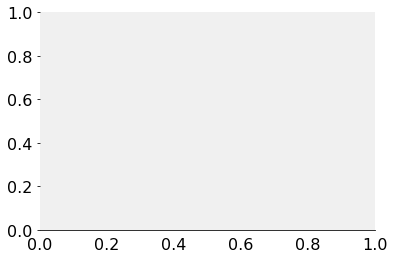

In [5]:
#def run(experiment_name, tsv_file, plots_dir):
experiment_name = 'ecoli_clr_1000_2errors_nointervals'
plots_dir = Path('plots')
df = read_astarix_performance('results/' + experiment_name + '.tsv')
print(df.head())
#df = df.append(read_astarix_performance('tmp/ecoli_head1000000_linear_long_clr/astar-default/alignments.tsv'), ignore_index=True)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name)
draw_one(df, y='t(map)', x='cost', hline=False, prefix=experiment_name)

KeyError: 'Column not found: explored_states'

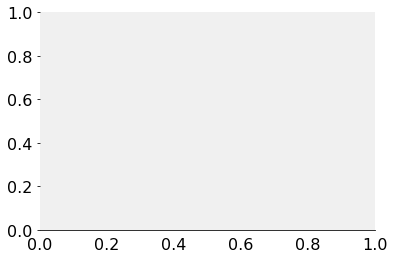

In [6]:
experiment_name = 'ecoli_ccs300'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_ccs_1000_0errors_intervals.tsv')
#df = df.append(read_astarix_performance('tmp/ecoli_head1000000_linear_long_clr/astar-default/alignments.tsv'), ignore_index=True)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, is_log=True)
draw_one(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, is_log=True)

                                       ref  refsize                   algo operation  memory  len                                               read                                              spell  cost  starts     pushed    popped  repeat_rate    t(map)  t(astar)  unique_best  pushed+popped
0  data/ecoli_head1000000_linear/graph.gfa  4317594  astar-seeds-intervals     align     0.0  409  TGACGTGCCGCCGCCAGGATCTGATGCCCTTGCTGGCTGAGTGTGC...  TGACGTGCCGCCGCCAGGATCTGATGCCCTTGCTGGCTGAGTGTGC...     7      -1   0.388753  0.090465          0.0  0.005328  0.000486            1       0.479218
1  data/ecoli_head1000000_linear/graph.gfa  4317594  astar-seeds-intervals     align     0.0  568  CCGCCAGTGATTACAGTTCCGTAGCAGCAGCTGGAGCGGTTCTTTT...  CCGCCAGTGATTACAGTTCCGTAGCAGCAGCTGGAGCGGTTCTTTt...    17      -1  13.209507  3.163732          0.0  0.121462  0.033809            1      16.373239
2  data/ecoli_head1000000_linear/graph.gfa  4317594  astar-seeds-intervals     align     0.0  125  CTGCGGAAAAGCG

KeyError: 'Column not found: explored_states'

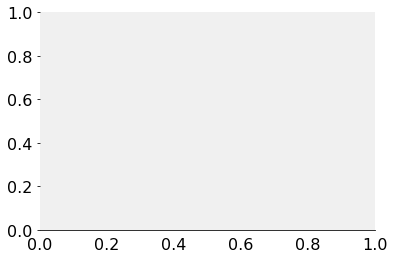

In [7]:
experiment_name = 'ecoli_ccs_1000_0errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_ccs_1000_0errors_intervals.tsv')
df = df.append(read_astarix_performance('results/ecoli_ccs_1000_0errors_nointervals.tsv'), ignore_index=True)

print(df.head())
print(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix='heuristic_'+experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals", show_mean=True)
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix='heuristic_'+experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals", show_mean=False)

                                       ref  refsize                   algo operation  memory  len                                               read                                              spell  cost  starts      pushed      popped  repeat_rate    t(map)  t(astar)  unique_best  pushed+popped
0  data/ecoli_head1000000_linear/graph.gfa  4317594  astar-seeds-intervals     align     0.0  888  AAAATCGGCCAGGCAGTGGAAATATTTTGCCCAGTTTTGAATTCGC...  AAAATCGGCCaGGcAGTGgAAATATTTTGCCCaGTTTtGAAttCGC...   168      -1  171.148649   72.917793          0.0  5.855488  3.169670            1     244.066442
1  data/ecoli_head1000000_linear/graph.gfa  4317594  astar-seeds-intervals     align     0.0  702  TTACAACTGTACGCAGGACTTTTAATGTTCTGCTTTCATCGCATAT...  TTACaACtGTACGCAGGAcTtTTAATGTTCTGCTttCAtCGCATAT...   130      -1  205.500000   88.206553          0.0  4.322737  1.822454            1     293.706553
2  data/ecoli_head1000000_linear/graph.gfa  4317594  astar-seeds-intervals     align     0.0  637  GCAG

KeyError: 'Column not found: explored_states'

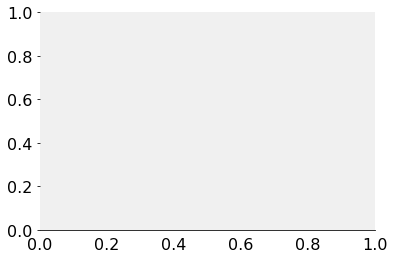

In [8]:
experiment_name = 'ecoli_clr_1000_2errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_clr_1000_2errors_intervals.tsv')
df = df.append(read_astarix_performance('results/ecoli_clr_1000_2errors_nointervals.tsv'), ignore_index=True)

print(df.head())
print(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals")
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals")

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped
0,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,TTACAGCATTACGCCAGACCTATGAAGAGGTCCTGCGACTGGCGGT...,TTAcAGCATTACGCCAGaCCTATGAAGAGGtCCTGCGACTGGCGGT...,4,680327,+,2053.544,326.044,0.0,4.553045,0.363206,1,100548,2379.588
1,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,CGACGGACAGCAATACTGAAAGCATCAGTCCTCCAGAAATAAGGCC...,CGACgGaCAGCAATACTGAAAGcATCAGTcCTCCaGAAATAAGGCC...,5,478551,+,6698.984,1178.312,0.0,16.542220,1.274704,1,381336,7877.296
2,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,GCGACGAGGCAATATTGGCGGCGAATGTCCGGCGCTGGCGACCACG...,GCGACGAGGCAAtATTgGCGGCGaATGTCCGGCGCTGGCGACCACG...,3,416599,+,432.508,60.888,0.0,1.343041,0.076406,1,18273,493.396
3,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,CCTTGTCCGTATGTTCCCAATCAAGTGCTGTACCGGGATTATCGAT...,CCTTgTCCgTATGtTCCCAATCAAGTGCTGTAcCGGGATTATCGAT...,4,390152,-,1851.224,279.500,0.0,4.059235,0.344760,1,82989,2130.724
4,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,ATCGGCACTGCTGATTTCACCATCCGTGCGTAAATAAAACCGGGTG...,ATCGGCAcTGcTGATTtCACCATcCGTGCGTAAATAAAACCGGGTG...,6,262724,+,16652.400,3395.772,0.0,44.376967,3.385134,1,1098552,20048.172


,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped
432,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,CTGTCAGCTACGACGCGCCACACTGTCCGCTTTGGCGGTGTACTGA...,CTGtCAGCTACGACGCGCCACACTGTCCGCTTTGGCGGTGTACTGA...,1,24388,-,0.816,0.084,0.0,0.002170,0.000298,1,260,0.900
433,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TGTTGTGGTTAATACCGGCTTTAGTCACTTCGTTCGACACCAGCTG...,tGTTGTGgTTAATACCGGCTTTaGTCAcTTCGTTcGACACCAGCTg...,6,109461,-,1.436,0.176,0.0,0.003279,0.000456,1,279,1.612
434,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TCTAGACCGCAAACACCAACCGATTTGTCGCATCGCTAATAACCTC...,TcTAgACcgCAAACacCAACCGATTTGTCgcaTCGCTAATAACCTC...,9,127438,-,4.280,0.544,0.0,0.009135,0.001359,1,374,4.824
435,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,AGCAAATCGGACCAAATTGCAGAGAACATGACACCGAACAGCGCAA...,AgCAAATCGGACCAAATTGCagAGAACATGACACCGAACAGCGCAA...,3,488727,-,0.716,0.088,0.0,0.002038,0.000268,1,259,0.804
436,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-seeds,align,0.0,250,TGGCGCATTTTCTGTACTATAACATTACCACTGACCTTACCGGGAA...,TGGCGCaTTTTCTgTACTATaACaTTACCaCTGACCTTACCGGGAA...,5,796261,+,1.168,0.124,0.0,0.002780,0.000381,1,266,1.292


KeyError: 'astar-prefix'

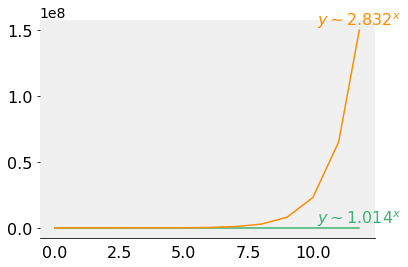

In [15]:
experiment_name = 'prefix_vs_seeds_ecoli_250_errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-prefix/alignments.tsv')
df = df.append(read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-seeds/alignments.tsv'), ignore_index=True)

display(df.head())
display(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, algo1="astar-prefix", algo2="astar-seeds")
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, algo1="astar-prefix", algo2="astar-seeds")

In [10]:
import seaborn as sns

def plot_states_per_kb(df):
    df['lenbin'] = (df['len'] // 150) * 150
    df['explored_per_bp'] = df['explored_states'] / df['len']
    fig, axes = plt.subplots()
    bylen = df.groupby(by='lenbin')
    display(bylen.mean())
    p = bylen['explored_per_bp'].plot(figsize=(15,5),legend=False,kind="bar",rot=45,color="blue",fontsize=16) #,yerr=bylen.std());
    #ax = sns.violinplot(x="lenbin", y="explored_per_bp", data=df)
    #ax = df[['explored_per_bp', 'lenbin']].boxplot(by='lenbin', showfliers=False)
    #ax.set_yscale('log')

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped
readname,,,,,,,,,,,,,,,,,,,
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435951,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435953,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435952,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782
S1_2,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,454,AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAAT...,AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAAT...,8,510400,-,0.370044,0.072687,0.0,0.002926,0.000439,1,477,0.442731
S1_3,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,493,TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTC...,TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTC...,10,46550,+,0.405680,0.107505,0.0,0.003784,0.000585,1,547,0.513185


,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped
readname,,,,,,,,,,,,,,,,,,,
S1_19996,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,518,AGCGGTTGATAGCAGTTTTCAATGCACCAAATGGAGGCGGTAAACG...,AGCGGTTGATAGCaGTTTTCAaTGCACCAAATGGAGGCGGTAAACG...,19,891215,-,4.328185,0.720077,0.0,0.040183,0.006390,1,907,5.048262
S1_19997,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,519,TACGGTACGGGTCAACTGCCGAAATTGCTGGCATCTGTTCCATACT...,TACGGTACGGGTCAACTGCCGAAATTGCTGGCATCTGTTCCATACT...,8,940050,+,1.107900,0.190751,0.0,0.017146,0.004364,1,616,1.298651
S1_19998,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,484,ACAGCCTGGCCATCATTACGCCATTCGTGCAGGTCGGACTTACCCG...,ACAGCCTGGCCATCATTACGCCATTCGTGCAGGTCGGACTTACCCG...,12,227270,-,0.789256,0.157025,0.0,0.008962,0.001720,1,554,0.946281
S1_19999,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,323,TTGCCGACATCCCCGAAGCCCTTGCCAACACCGTTGAGATCGCCAA...,TTGCCGACATCCCCGAAGCCCTTGCCAACACCGTTGAGATCGCCAA...,3,205879,+,0.442724,0.061920,0.0,0.005810,0.000629,1,332,0.504644
S1_20000,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,457,ATAATATTTATTATCATCAAGTACCAGTCCCACCGAGTCTAAAAAT...,ATAATATTTATTATCATCAAGTACCAGTCCCACCGAGTCTAAAAAT...,7,872843,-,0.391685,0.076586,0.0,0.004731,0.000694,1,484,0.468271


,refsize,memory,len,cost,start,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,explored_per_bp
lenbin,,,,,,,,,,,,,,
0,2298534.0,0.0,138.157895,2.789474,448764.877193,2.636503,0.438610,0.0,0.004517,0.000341,0.894737,189.859649,3.075113,1.381103
150,2298534.0,0.0,250.680869,4.667607,496358.592551,1.992512,0.364151,0.0,0.006322,0.000666,0.928894,339.958804,2.356662,1.354496
300,2298534.0,0.0,373.993168,7.014743,492548.260098,2.068758,0.406864,0.0,0.010410,0.001557,0.922929,531.912861,2.475623,1.418336
450,2298534.0,0.0,515.199819,9.610840,489687.600000,2.374416,0.503046,0.0,0.017717,0.003723,0.927191,795.844625,2.877462,1.541848
600,2298534.0,0.0,660.326981,12.613686,489451.742746,2.991591,0.673032,0.0,0.031327,0.008721,0.928540,1178.055002,3.664624,1.782438
750,2298534.0,0.0,811.371134,16.127577,491460.353093,3.652351,0.906541,0.0,0.053027,0.018021,0.925258,1691.822165,4.558892,2.076616
900,2298534.0,0.0,955.895753,19.833977,518011.679537,4.125406,1.033351,0.0,0.080767,0.034103,0.965251,2201.212355,5.158757,2.299439
1050,2298534.0,0.0,1113.250000,22.294118,455346.573529,4.473264,1.117382,0.0,0.117247,0.057808,1.000000,2610.117647,5.590646,2.337304
1200,2298534.0,0.0,1259.105263,28.815789,485110.552632,5.893768,1.633869,0.0,0.202608,0.110186,0.842105,4162.210526,7.527637,3.305773


len


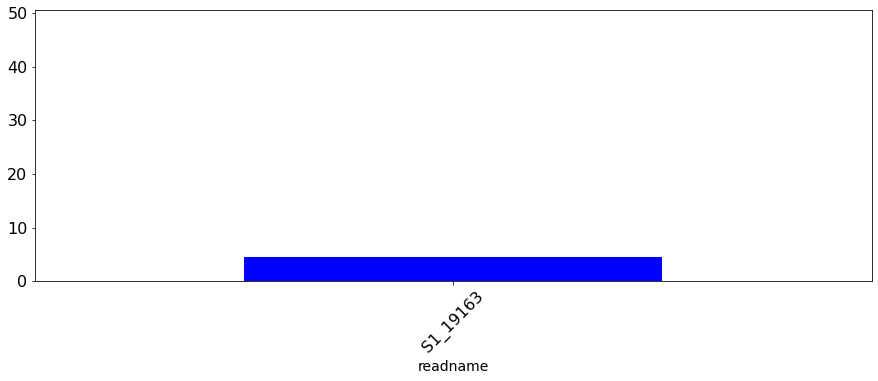

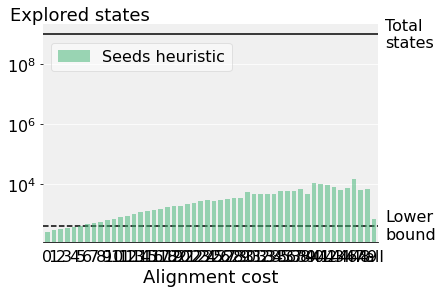

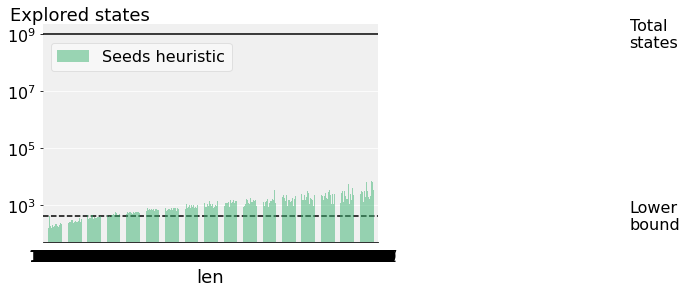

In [11]:
experiment_name = 'seeds_length_scaling_ccs'
plots_dir = Path('plots')
df = read_astarix_performance('../tmp/ecoli_head1000000_linear_ccs/astar-seeds/alignments.tsv')

display(df.head())
display(df.tail())

plot_states_per_kb(df)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, is_log=True)
draw_one(df, y='explored_states', x='len', hline=True, prefix=experiment_name, is_log=True)

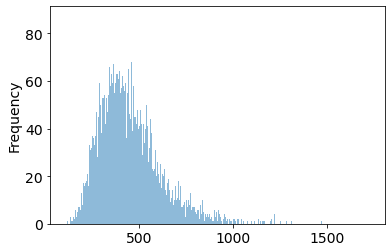

In [12]:
ax = df['len'].plot.hist(bins=max(df['len'])-min(df['len'])+1, alpha=0.5)

<AxesSubplot:xlabel='len', ylabel='explored_states'>

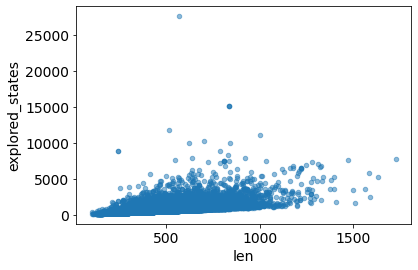

In [13]:
df.plot.scatter(x='len', y='explored_states', alpha=0.5)

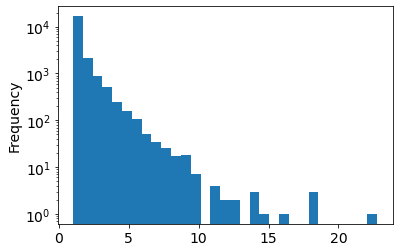

In [14]:
ax = df.loc[df['explored_per_bp'] < 30]['explored_per_bp'].plot.hist(bins=31)
ax.set_yscale('log')

In [16]:
df.loc[df['explored_per_bp'] < 1.0]

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,lenbin,explored_per_bp
readname,,,,,,,,,,,,,,,,,,,,,
